In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from karateclub.dataset import GraphSetReader
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from karateclub import LDP, GL2Vec, Graph2Vec

import glob
from py2neo import NodeMatcher, Graph, Node, Relationship

In [3]:
graph = Graph(password="12345")

def graphdata1(label_n1, value_n1, link, label_n2, value_n2):
    node1 = graph.nodes.match(label_n1, name=value_n1).first()
    node2 = graph.nodes.match(label_n2, name=value_n2).first()
    if not node1:
        node1 = Node(label_n1, name=value_n1)
    if not node2:
        node2 = Node(label_n2, name=value_n2)
    newnodelink = Relationship(node1, link, node2)
    graph.create(newnodelink)
    
def getgraphsample(filename):
    df = pd.read_csv(filename)
    
    for index, row in df.iterrows():
        graphdata1(row['u_label'], row['u_value'], row['link'], row['v_label'], row['v_value'])
    
    G = nx.Graph()
    
    cquery = """
    MATCH (u)-[r]->(v) 
    RETURN u.name as u_name, type(r) as link, v.name as v_name
    """
    getalllinks = graph.run(cquery).to_data_frame()
    node1 = pd.factorize( getalllinks['u_name'] )[0]
    node2 = pd.factorize( getalllinks['v_name'] )[0]
    
    for u, v in zip(node1, node2):
        G.add_node(u, feature = getalllinks['u_name'])
        G.add_node(v, feature = getalllinks['v_name'])
        G.add_edge(u, v, featuree = getalllinks['link'])
        
    return G

In [4]:
X_train = []
y_train = []

for file in glob.glob("data/*.csv"):
    graph.delete_all()
    X_train.append(getgraphsample(file))
    y_train.append(file.split('_')[2])
    
y_train = pd.factorize(y_train)[0]

In [5]:
X_train

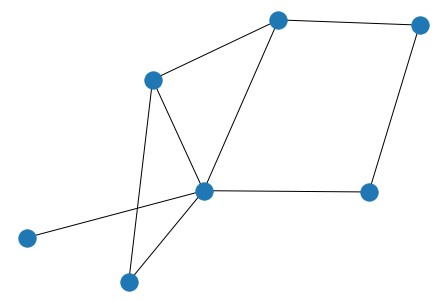

In [531]:
nx.draw(graphdata[1])

In [9]:
def kmeans(dim, epo):
    model = Graph2Vec(dimensions=dim, epochs=epo)
    model.fit(X_train)
    X_embedding = model.get_embedding()

    initkmeans = KMeans(n_clusters=3, random_state=47)
    y_pred = initkmeans.fit_predict(X_embedding)
    f1score = f1_score(y_train, y_pred, average='micro')
    print(y_train, y_pred)
    return f1score

In [10]:
print(kmeans(50,100))

[0 0 0 0 1 1 1 1 2] [2 2 0 1 1 2 0 2 0]
0.2222222222222222


c:\users\16sic\appdata\local\programs\python\python37\lib\site-packages\gensim\models\doc2vec.py:315: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
